## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
import tensorflow
from keras.datasets import cifar10

# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

2021-11-19 14:35:41.097798: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-19 14:35:41.097939: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
num_classes = 10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.np_utils.to_categorical(y, num_classes)
    return y    

In [7]:
# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [15]:
from keras.regularizers import l1, l2, l1_l2
def build_mlp(input_shape, regularization, ratio, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    if regularization == "l1":
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1(ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1(ratio))(x)

    elif regularization == "l2":
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l2(ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l2(ratio))(x)
    else:
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1_l2(ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1_l2(ratio))(x)
    
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [16]:
## 超參數設定
"""
Set your required experiment parameters
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
REGULARIZATION = ["l1", "l2", "l1_l2"]
EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [19]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regularization in REGULARIZATION:
    for regularier_ratio in EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print(f"Regularization: {regularization}, Ratio: {regularier_ratio}")
        model = build_mlp(input_shape=x_train.shape[1:], 
                          regularization=regularization, 
                          ratio=regularier_ratio,
                          output_units=10, num_neurons=[512, 256, 128])
        model.summary()
        
        optimizer = keras.optimizers.gradient_descent_v2.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        
        model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
        
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]

        exp_name_tag = "Regularization: %s, Ratio: %s" %(regularization, str(regularier_ratio))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}        


Regularization: l1, Ratio: 0.01
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


2021-11-19 15:08:51.018395: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.
2021-11-19 15:08:51.435705: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
196/196 [==============================] - 6s 27ms/step - loss: 198.5562 - accuracy: 0.1120 - val_loss: 40.8952 - val_accuracy: 0.1000
Epoch 2/50
196/196 [==============================] - 4s 22ms/step - loss: 18.9915 - accuracy: 0.0970 - val_loss: 7.2186 - val_accuracy: 0.1000
Epoch 3/50
196/196 [==============================] - 4s 22ms/step - loss: 4.0750 - accuracy: 0.0983 - val_loss: 2.6311 - val_accuracy: 0.1000
Epoch 4/50
196/196 [==============================] - 4s 22ms/step - loss: 2.4824 - accuracy: 0.0988 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 5/50
196/196 [==============================] - 4s 22ms/step - loss: 2.4628 - accuracy: 0.0975 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 6/50
196/196 [==============================] - 4s 22ms/step - loss: 2.4628 - accuracy: 0.0982 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 7/50
196/196 [==============================] - 4s 22ms/step - loss: 2.4628 - accuracy: 0.0986 - val_loss: 2.4625 - val_accuracy: 0.

2021-11-19 15:12:20.766102: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/50
196/196 [==============================] - 5s 23ms/step - loss: 6.2772 - accuracy: 0.1411 - val_loss: 6.2434 - val_accuracy: 0.1316
Epoch 2/50
196/196 [==============================] - 4s 19ms/step - loss: 6.2099 - accuracy: 0.1372 - val_loss: 6.1759 - val_accuracy: 0.1615
Epoch 3/50
196/196 [==============================] - 4s 20ms/step - loss: 6.1428 - accuracy: 0.1366 - val_loss: 6.1092 - val_accuracy: 0.1823
Epoch 4/50
196/196 [==============================] - 4s 20ms/step - loss: 6.0765 - accuracy: 0.1709 - val_loss: 6.0432 - val_accuracy: 0.1715
Epoch 5/50
196/196 [==============================] - 4s 21ms/step - loss: 6.0108 - accuracy: 0.1339 - val_loss: 5.9778 - val_accuracy: 0.1523
Epoch 6/50
196/196 [==============================] - 4s 21ms/step - loss: 5.9457 - accuracy: 0.1478 - val_loss: 5.9130 - val_accuracy: 0.1522
Epoch 7/50
196/196 [==============================] - 4s 19ms/step - loss: 5.8812 - accuracy: 0.1337 - val_loss: 5.8489 - val_accuracy: 0.1650

2021-11-19 15:15:42.240694: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/50
196/196 [==============================] - 4s 21ms/step - loss: 2.3023 - accuracy: 0.1355 - val_loss: 2.3018 - val_accuracy: 0.1582
Epoch 2/50
196/196 [==============================] - 4s 19ms/step - loss: 2.3017 - accuracy: 0.1435 - val_loss: 2.3015 - val_accuracy: 0.1645
Epoch 3/50
196/196 [==============================] - 4s 19ms/step - loss: 2.3014 - accuracy: 0.1373 - val_loss: 2.3012 - val_accuracy: 0.1259
Epoch 4/50
196/196 [==============================] - 4s 19ms/step - loss: 2.3012 - accuracy: 0.1411 - val_loss: 2.3010 - val_accuracy: 0.2096
Epoch 5/50
196/196 [==============================] - 4s 19ms/step - loss: 2.3010 - accuracy: 0.1683 - val_loss: 2.3009 - val_accuracy: 0.1496
Epoch 6/50
196/196 [==============================] - 4s 20ms/step - loss: 2.3009 - accuracy: 0.1598 - val_loss: 2.3007 - val_accuracy: 0.2083
Epoch 7/50
196/196 [==============================] - 4s 20ms/step - loss: 2.3007 - accuracy: 0.1569 - val_loss: 2.3005 - val_accuracy: 0.1992

2021-11-19 15:19:05.782116: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/50
196/196 [==============================] - 4s 21ms/step - loss: 2.3020 - accuracy: 0.1349 - val_loss: 2.3016 - val_accuracy: 0.1787
Epoch 2/50
196/196 [==============================] - 4s 19ms/step - loss: 2.3015 - accuracy: 0.1372 - val_loss: 2.3014 - val_accuracy: 0.1343
Epoch 3/50
196/196 [==============================] - 4s 20ms/step - loss: 2.3014 - accuracy: 0.1495 - val_loss: 2.3012 - val_accuracy: 0.1889
Epoch 4/50
196/196 [==============================] - 4s 21ms/step - loss: 2.3012 - accuracy: 0.1576 - val_loss: 2.3011 - val_accuracy: 0.1648
Epoch 5/50
196/196 [==============================] - 5s 24ms/step - loss: 2.3011 - accuracy: 0.1420 - val_loss: 2.3010 - val_accuracy: 0.1598
Epoch 6/50
196/196 [==============================] - 5s 24ms/step - loss: 2.3010 - accuracy: 0.1407 - val_loss: 2.3008 - val_accuracy: 0.1350
Epoch 7/50
196/196 [==============================] - 4s 22ms/step - loss: 2.3008 - accuracy: 0.1559 - val_loss: 2.3006 - val_accuracy: 0.1971

2021-11-19 15:22:38.884143: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/50
196/196 [==============================] - 5s 22ms/step - loss: 15.3441 - accuracy: 0.1379 - val_loss: 14.3522 - val_accuracy: 0.1014
Epoch 2/50
196/196 [==============================] - 4s 22ms/step - loss: 13.4562 - accuracy: 0.1379 - val_loss: 12.5914 - val_accuracy: 0.1000
Epoch 3/50
196/196 [==============================] - 4s 20ms/step - loss: 11.8264 - accuracy: 0.1003 - val_loss: 11.0880 - val_accuracy: 0.1045
Epoch 4/50
196/196 [==============================] - 4s 20ms/step - loss: 10.4348 - accuracy: 0.1185 - val_loss: 9.8043 - val_accuracy: 0.1160
Epoch 5/50
196/196 [==============================] - 4s 21ms/step - loss: 9.2465 - accuracy: 0.1106 - val_loss: 8.7082 - val_accuracy: 0.1000
Epoch 6/50
196/196 [==============================] - 5s 24ms/step - loss: 8.2319 - accuracy: 0.1111 - val_loss: 7.7722 - val_accuracy: 0.1044
Epoch 7/50
196/196 [==============================] - 4s 21ms/step - loss: 7.3656 - accuracy: 0.1177 - val_loss: 6.9730 - val_accuracy:

Epoch 1/50
196/196 [==============================] - 5s 22ms/step - loss: 2.4410 - accuracy: 0.1254 - val_loss: 2.4405 - val_accuracy: 0.1002
Epoch 2/50
196/196 [==============================] - 4s 20ms/step - loss: 2.4403 - accuracy: 0.1356 - val_loss: 2.4400 - val_accuracy: 0.1527
Epoch 3/50
196/196 [==============================] - 4s 20ms/step - loss: 2.4399 - accuracy: 0.1315 - val_loss: 2.4396 - val_accuracy: 0.1626
Epoch 4/50
196/196 [==============================] - 4s 20ms/step - loss: 2.4395 - accuracy: 0.1247 - val_loss: 2.4393 - val_accuracy: 0.1237
Epoch 5/50
196/196 [==============================] - 4s 20ms/step - loss: 2.4391 - accuracy: 0.1480 - val_loss: 2.4389 - val_accuracy: 0.1756
Epoch 6/50
196/196 [==============================] - 5s 25ms/step - loss: 2.4388 - accuracy: 0.1529 - val_loss: 2.4385 - val_accuracy: 0.1833
Epoch 7/50
196/196 [==============================] - 4s 23ms/step - loss: 2.4384 - accuracy: 0.1607 - val_loss: 2.4382 - val_accuracy: 0.1185

Epoch 1/50
196/196 [==============================] - 5s 23ms/step - loss: 2.3019 - accuracy: 0.1308 - val_loss: 2.3015 - val_accuracy: 0.1738
Epoch 2/50
196/196 [==============================] - 4s 21ms/step - loss: 2.3014 - accuracy: 0.1435 - val_loss: 2.3012 - val_accuracy: 0.1721
Epoch 3/50
196/196 [==============================] - 4s 21ms/step - loss: 2.3011 - accuracy: 0.1388 - val_loss: 2.3009 - val_accuracy: 0.1890
Epoch 4/50
196/196 [==============================] - 4s 21ms/step - loss: 2.3009 - accuracy: 0.1350 - val_loss: 2.3007 - val_accuracy: 0.1483
Epoch 5/50
196/196 [==============================] - 4s 22ms/step - loss: 2.3006 - accuracy: 0.1561 - val_loss: 2.3004 - val_accuracy: 0.1510
Epoch 6/50
196/196 [==============================] - 4s 22ms/step - loss: 2.3004 - accuracy: 0.1584 - val_loss: 2.3002 - val_accuracy: 0.1904
Epoch 7/50
196/196 [==============================] - 4s 22ms/step - loss: 2.3002 - accuracy: 0.1585 - val_loss: 2.3000 - val_accuracy: 0.1245

Epoch 1/50
196/196 [==============================] - 6s 27ms/step - loss: 2.3019 - accuracy: 0.1398 - val_loss: 2.3015 - val_accuracy: 0.1022
Epoch 2/50
196/196 [==============================] - 4s 22ms/step - loss: 2.3015 - accuracy: 0.1493 - val_loss: 2.3013 - val_accuracy: 0.1441
Epoch 3/50
196/196 [==============================] - 4s 22ms/step - loss: 2.3013 - accuracy: 0.1593 - val_loss: 2.3011 - val_accuracy: 0.1896
Epoch 4/50
196/196 [==============================] - 6s 29ms/step - loss: 2.3011 - accuracy: 0.1421 - val_loss: 2.3009 - val_accuracy: 0.1992
Epoch 5/50
196/196 [==============================] - 4s 22ms/step - loss: 2.3009 - accuracy: 0.1476 - val_loss: 2.3008 - val_accuracy: 0.1722
Epoch 6/50
196/196 [==============================] - 4s 22ms/step - loss: 2.3008 - accuracy: 0.1442 - val_loss: 2.3006 - val_accuracy: 0.1868
Epoch 7/50
196/196 [==============================] - 4s 20ms/step - loss: 2.3006 - accuracy: 0.1329 - val_loss: 2.3004 - val_accuracy: 0.1686

Epoch 1/50
196/196 [==============================] - 11s 29ms/step - loss: 197.8095 - accuracy: 0.1005 - val_loss: 35.6956 - val_accuracy: 0.1000
Epoch 2/50
196/196 [==============================] - 5s 26ms/step - loss: 15.8189 - accuracy: 0.0985 - val_loss: 5.1152 - val_accuracy: 0.1000
Epoch 3/50
196/196 [==============================] - 5s 26ms/step - loss: 3.2053 - accuracy: 0.0979 - val_loss: 2.4705 - val_accuracy: 0.1000
Epoch 4/50
196/196 [==============================] - 5s 26ms/step - loss: 2.4629 - accuracy: 0.0978 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 5/50
196/196 [==============================] - 5s 26ms/step - loss: 2.4624 - accuracy: 0.0983 - val_loss: 2.4624 - val_accuracy: 0.1000
Epoch 6/50
196/196 [==============================] - 5s 26ms/step - loss: 2.4624 - accuracy: 0.0976 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 7/50
196/196 [==============================] - 5s 26ms/step - loss: 2.4623 - accuracy: 0.0969 - val_loss: 2.4622 - val_accuracy: 0

Epoch 1/50
196/196 [==============================] - 6s 29ms/step - loss: 19.0848 - accuracy: 0.1258 - val_loss: 17.7757 - val_accuracy: 0.1273
Epoch 2/50
196/196 [==============================] - 6s 30ms/step - loss: 16.5932 - accuracy: 0.1218 - val_loss: 15.4521 - val_accuracy: 0.1101
Epoch 3/50
196/196 [==============================] - 5s 28ms/step - loss: 14.4428 - accuracy: 0.1173 - val_loss: 13.4687 - val_accuracy: 0.1309
Epoch 4/50
196/196 [==============================] - 5s 26ms/step - loss: 12.6073 - accuracy: 0.1157 - val_loss: 11.7759 - val_accuracy: 0.1403
Epoch 5/50
196/196 [==============================] - 5s 26ms/step - loss: 11.0408 - accuracy: 0.1152 - val_loss: 10.3313 - val_accuracy: 0.1185
Epoch 6/50
196/196 [==============================] - 6s 29ms/step - loss: 9.7040 - accuracy: 0.1141 - val_loss: 9.0986 - val_accuracy: 0.1000
Epoch 7/50
196/196 [==============================] - 5s 26ms/step - loss: 8.5634 - accuracy: 0.1029 - val_loss: 8.0470 - val_accura

Epoch 1/50
196/196 [==============================] - 6s 28ms/step - loss: 15.3558 - accuracy: 0.1193 - val_loss: 14.3630 - val_accuracy: 0.1287
Epoch 2/50
196/196 [==============================] - 5s 26ms/step - loss: 13.4662 - accuracy: 0.1455 - val_loss: 12.6006 - val_accuracy: 0.1626
Epoch 3/50
196/196 [==============================] - 5s 26ms/step - loss: 11.8349 - accuracy: 0.1442 - val_loss: 11.0958 - val_accuracy: 0.1955
Epoch 4/50
196/196 [==============================] - 5s 27ms/step - loss: 10.4420 - accuracy: 0.1201 - val_loss: 9.8110 - val_accuracy: 0.1466
Epoch 5/50
196/196 [==============================] - 5s 26ms/step - loss: 9.2527 - accuracy: 0.1104 - val_loss: 8.7138 - val_accuracy: 0.1314
Epoch 6/50
196/196 [==============================] - 5s 26ms/step - loss: 8.2372 - accuracy: 0.1122 - val_loss: 7.7770 - val_accuracy: 0.1443
Epoch 7/50
196/196 [==============================] - 5s 26ms/step - loss: 7.3700 - accuracy: 0.1081 - val_loss: 6.9771 - val_accuracy:

Epoch 1/50
196/196 [==============================] - 6s 28ms/step - loss: 15.3286 - accuracy: 0.1273 - val_loss: 14.3379 - val_accuracy: 0.1044
Epoch 2/50
196/196 [==============================] - 5s 27ms/step - loss: 13.4429 - accuracy: 0.1380 - val_loss: 12.5792 - val_accuracy: 0.1415
Epoch 3/50
196/196 [==============================] - 5s 27ms/step - loss: 11.8151 - accuracy: 0.1318 - val_loss: 11.0776 - val_accuracy: 0.1636
Epoch 4/50
196/196 [==============================] - 5s 27ms/step - loss: 10.4251 - accuracy: 0.1153 - val_loss: 9.7954 - val_accuracy: 0.1293
Epoch 5/50
196/196 [==============================] - 5s 27ms/step - loss: 9.2383 - accuracy: 0.1132 - val_loss: 8.7006 - val_accuracy: 0.1458
Epoch 6/50
196/196 [==============================] - 5s 27ms/step - loss: 8.2249 - accuracy: 0.1091 - val_loss: 7.7657 - val_accuracy: 0.1348
Epoch 7/50
196/196 [==============================] - 5s 27ms/step - loss: 7.3595 - accuracy: 0.1113 - val_loss: 6.9674 - val_accuracy:

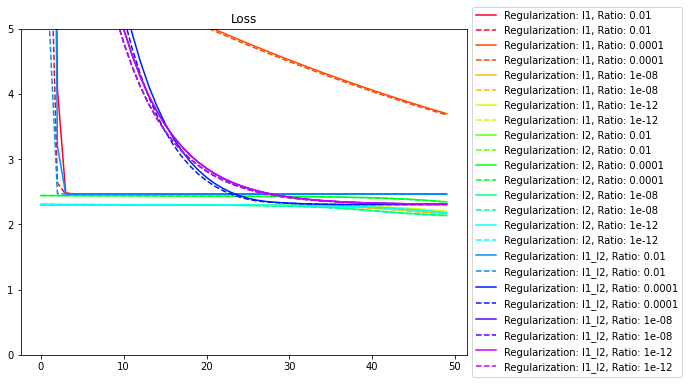

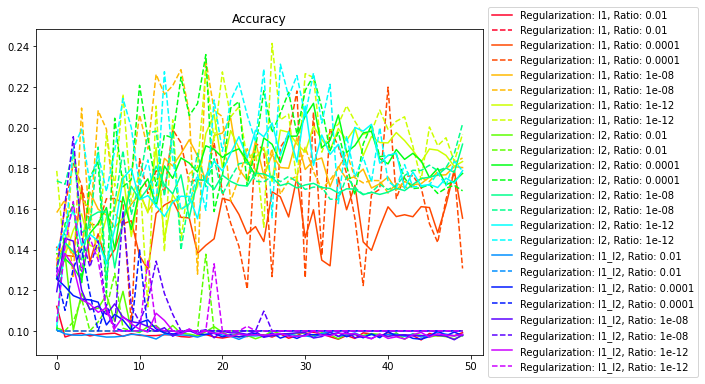

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline

NUM_COLORS = 12
cm = plt.get_cmap('gist_rainbow')
cNorm = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [ scalarMap.to_rgba(i) for i in range(NUM_COLORS)]
"""Code Here
將結果繪出
"""

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()